For this assignment I have chosen the Titanic dataset, because it sounded the most interesting. I will first load it and display the list of passengers:

In [6]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now I will do some data clean-up: drop the Cabin column (too many items missing) and fill in the missing Ages and Embarkation statuses.

In [7]:
# Drop 'Cabin'
df = df.drop(columns=['Cabin'])

# Fill missing 'Age' with the median (safe syntax)
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing 'Embarked' with the mode (safe syntax)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Drop any duplicate rows
df = df.drop_duplicates()

Now time for some final sanity checks for inconsistent data:

In [26]:

# Double check for missing values
print(df.isnull().sum())

print(df['Embarked'].unique())  # should be 'C', 'Q', 'S'

# Check for negative values in 'Fare' and 'Age'
print(df[df['Fare'] < 0])  # shouldn't happen
print(df[df['Age'] < 0])   # also shouldn't happen

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
['S' 'C' 'Q']
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []


All the data looks right! Time to look for some outliers in age and fare:

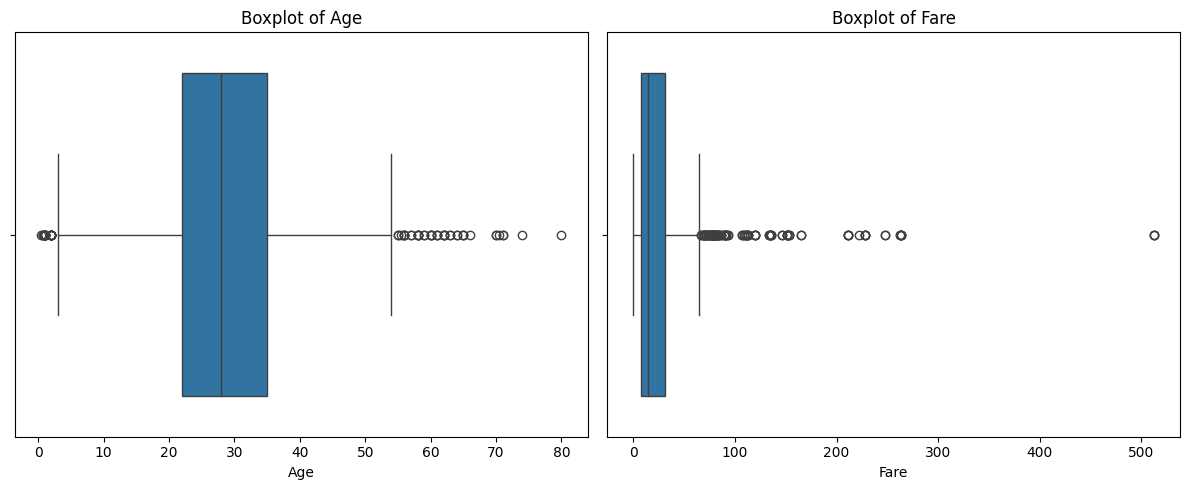

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplots to visualize outliers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Age'])
plt.title('Boxplot of Age')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Fare'])
plt.title('Boxplot of Fare')

plt.tight_layout()
plt.show()


Outliers can be seen in both Fare and Age. However, these values are consistent with real-world expectations (wealthy passengers or elderly individuals). Therefore, we won't remove any rows, but we might apply a transformation such as log scaling later during modeling.



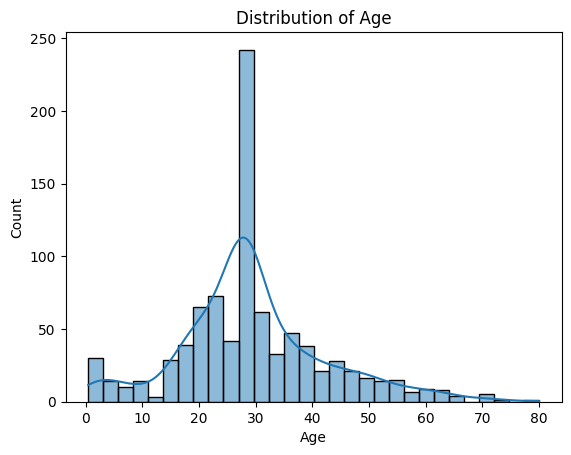

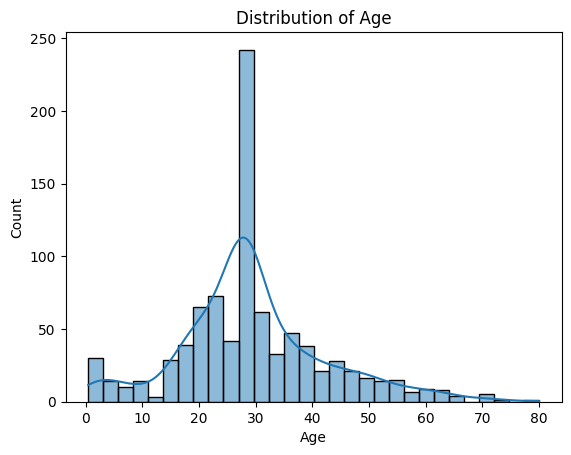

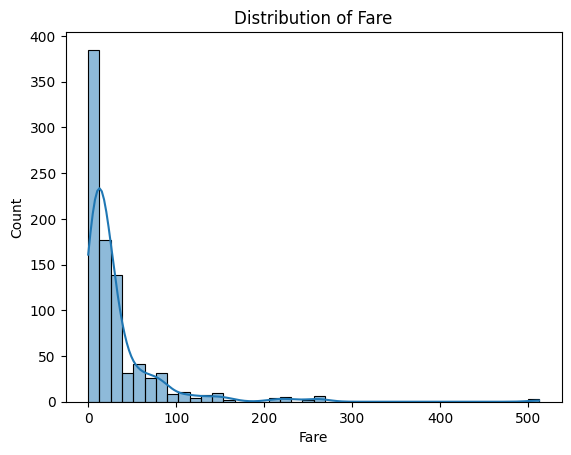

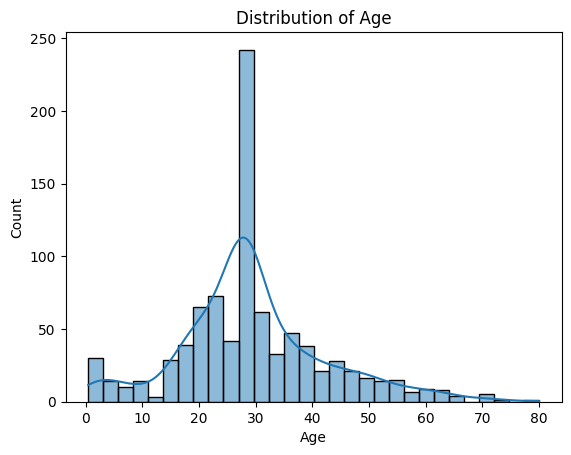

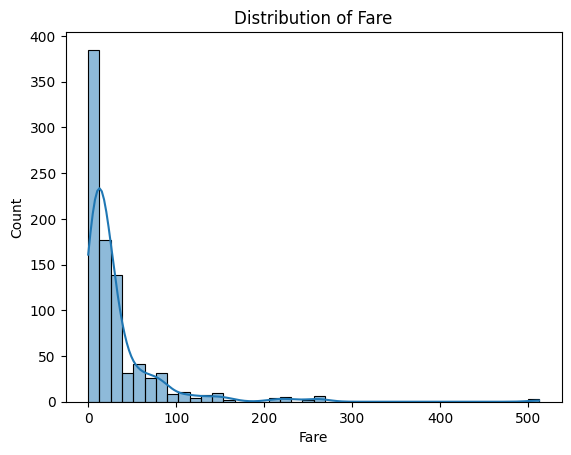

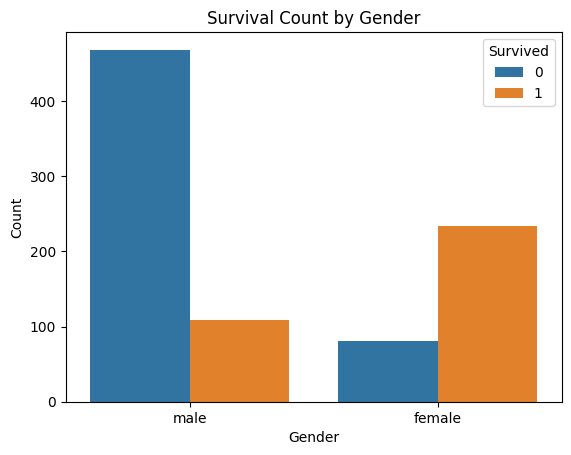

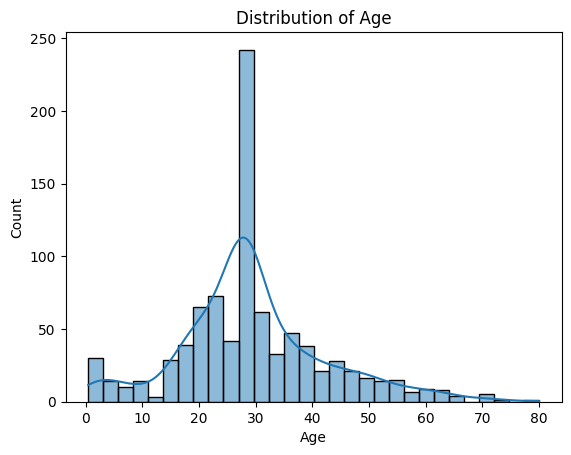

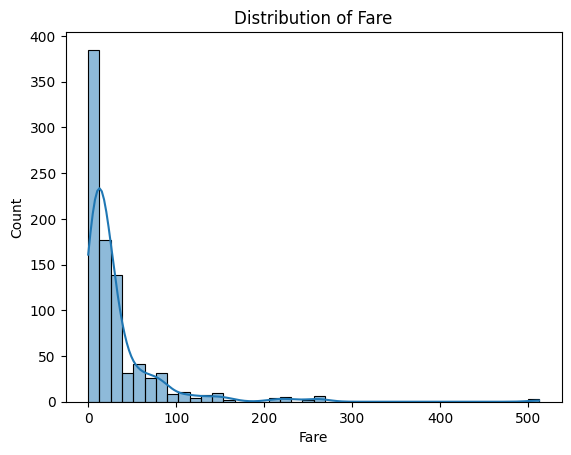

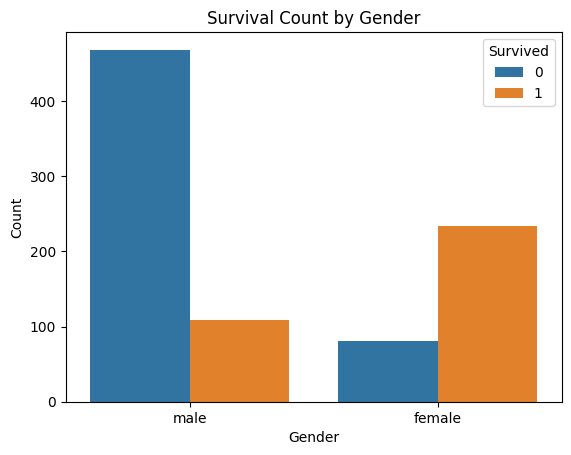

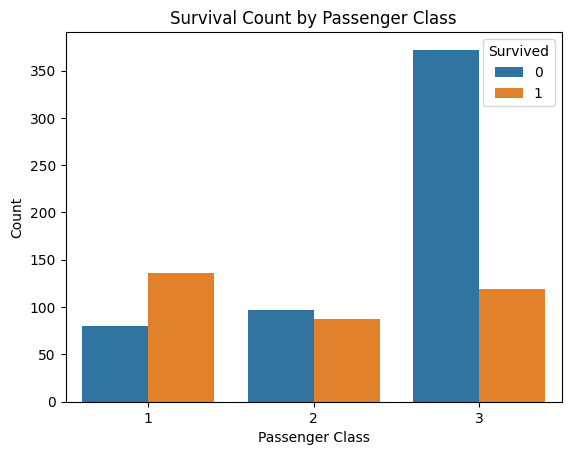

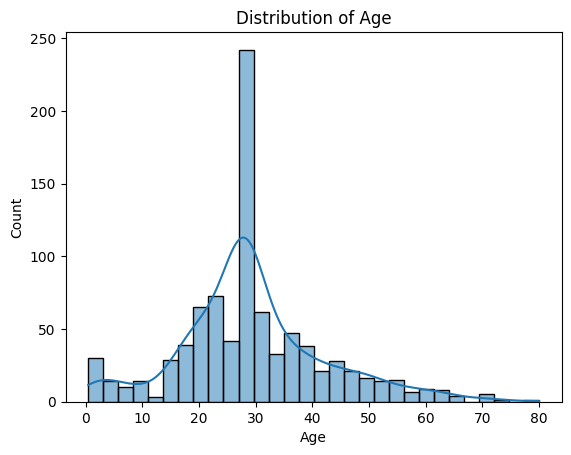

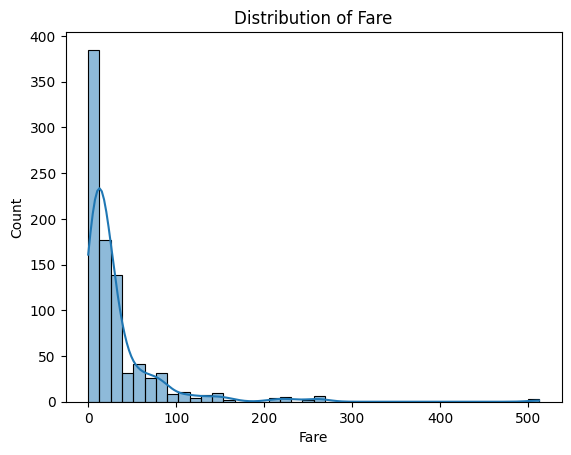

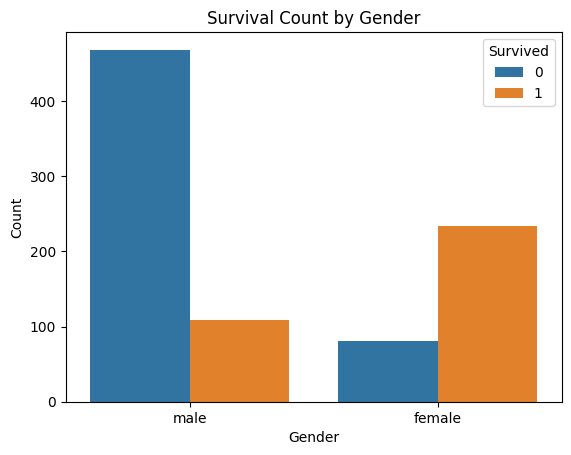

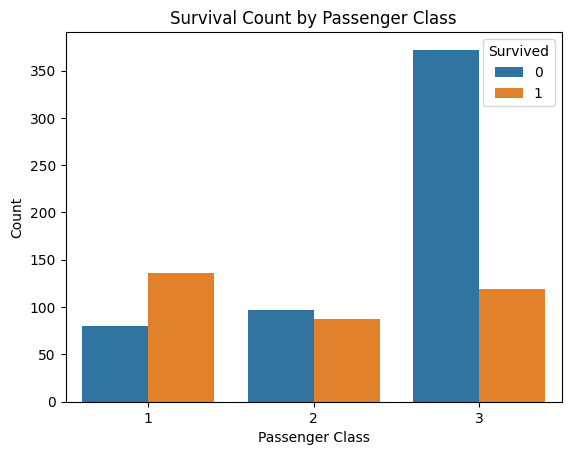

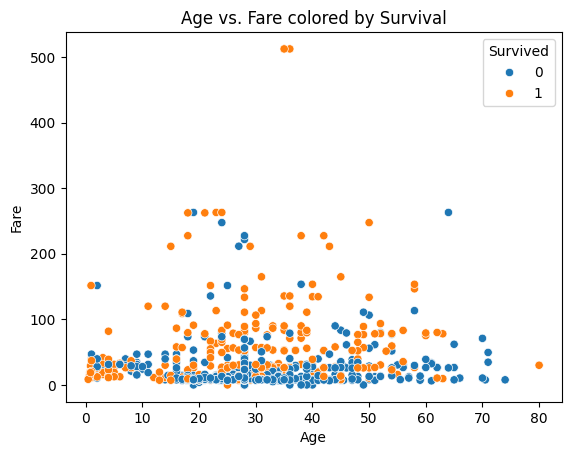

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Age
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 2. Distribution of Fare
sns.histplot(df['Fare'], kde=True, bins=40)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()

# 3. Survival count by gender
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show()

# 4. Survival by passenger class
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show()

# 5. Age vs. Fare colored by survival
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df)
plt.title('Age vs. Fare colored by Survival')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Survived')
plt.show()


### Exploratory Data Analysis (EDA)

Most passengers are in their 20s–30s. There are also some infants and older adults, but nothing too weird or extreme.

Fare is heavily skewed — most people paid under \$50, but a few went way over \$500. 

Survival patterns stood out:
- Women had much higher survival rates than men: lines up with “women and children first”.
- People in 1st class were way more likely to survive compared to 3rd class.

When looking at age vs fare, survivors leaned toward higher fares, which makes sense given the class difference. There's also a small but clear cluster of younger, wealthier survivors.

### Future modeling

This gave us a pretty good idea of what features will matter later. Gender and class are clearly important, so I’ll definitely use them in classification models. Since `Fare` is very skewed, we might log-transform it to make things more stable. Also, the relationships don’t look very linear, so tree-based models might work better than linear ones.

Since the relationships in the data don’t look very linear and there’s a mix of numeric and categorical features, the bets approach seems to be with tree-based models like Decision Trees or Random Forests. They usually perform better in this kind of setup and don’t need as much preprocessing.



# Deliverable 2

Now I will add two new features to improve the dataset for modeling:

Title extraction from Name: This feature pulls out the passenger's title (Mr, Mrs, Miss, etc.) from the Name column. Titles often reflect social status, which can affect survival odds.

FamilySize: This feature combines the number of siblings/spouses (`SibSp`) and parents/children (`Parch`) traveling with the passenger, plus one (the passenger themselves). Family size can influence survival, as people traveling alone or in large groups may have different outcomes.

These engineered features should help the model better capture important patterns in the data.

In [48]:
# Add Title feature by extracting from Name
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.') # this regex captures the title after the comma and before the period
print(df['Title'].value_counts())  # quick check of extracted titles

# Add FamilySize feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
print(df[['SibSp', 'Parch', 'FamilySize']].head())  # quick check

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64
   SibSp  Parch  FamilySize
0      1      0           2
1      1      0           2
2      0      0           1
3      1      0           2
4      0      0           1


The new features look good!

Title: Most passengers are Mr, Miss, Mrs, or Master, but there are also rare titles like Dr, Rev, and nobility. These can help the model pick up on social status and its effect on survival.

FamilySize: Most people traveled alone or with one other person, but there are some larger families. This feature will help the model understand group survival patterns.

Both features add useful information for future modeling.

## Regression Modelling to determine survival

I'll build two regression models to predict passenger fare using the new features and other relevant columns. I'll use Linear Regression as a baseline, and Ridge Regression to see if regularization helps.

For both models, I'll use Pclass, Sex, Age, FamilySize, and Title. The goal is to see how well these features explain the variation in fare prices.

In [ ]:
# Features for regression
features = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Title']
X = df[features]
X['Sex'] = (X['Sex'] == 'male').astype(int)  # male=1, female=0
y_log = df['LogFare'] # Log-transform Fare to stabilize for variance
le_title = LabelEncoder()
X['Title'] = le_title.fit_transform(X['Title'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Linear Regression on log(Fare)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f'Linear MSE: {mse_lin:.10f}')

# Ridge Regression on log(Fare)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge MSE: {mse_ridge:.10f}')

/var/folders/6b/mkrflm9150qd0xn0m2ny51wm0000gn/T/ipykernel_51580/1048883334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = (X['Sex'] == 'male').astype(int)  # male=1, female=0


ValueError: could not convert string to float: 'Mr'

Both Linear Regression and Ridge Regression produced very similar MSE values on the log-transformed Fare target.

This indicates that Ridge did not significantly improve model performance over Linear. The log transformation however helped reduce the impact of outliers and skewness in Fare, resulting in lower and more stable error values.

In [ ]:
# Cross-validation for Linear and Ridge Regression on log-transformed Fare
from sklearn.model_selection import cross_val_score

# Features and target
features = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Title_encoded']
X = df[features]
y_log = df['LogFare']

# Linear Regression cross-validation (negative MSE)
linreg = LinearRegression()
cv_mse_lin = cross_val_score(linreg, X, y_log, cv=5, scoring='neg_mean_squared_error')
print('Linear CV MSE:', -cv_mse_lin.mean())

# Ridge Regression cross-validation (negative MSE)
ridge = Ridge(alpha=1.0)
cv_mse_ridge = cross_val_score(ridge, X, y_log, cv=5, scoring='neg_mean_squared_error')
print('Ridge CV MSE:', -cv_mse_ridge.mean())

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 601, in fit
    X, y = validate_data(
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/Users/nichita/opt/miniconda3/lib/python3.9/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'male'


## Conclusion

We can see above that Linear Regression and Ridge Regression models achieved nearly identical MSE values on the log-transformed Fare target.

This indicates that Ridge regularization does not provide a significant advantage over the standard Linear Regression for this set. The log transformation of Fare helped stabilize error values and reduce the impact of outliers.

Cross-validation confirms that both models generalize similarly, with stable performance and no signs of overfitting.

Overall, the regression models provide a robust baseline for predicting Fare, and the cross-validation results support their reliability.

# Deliverable 3 - Classification, Clustering and Pattern Mining

This is the most interesting deliverable for our dataset. We can use classification to predict whether passengers survived the sinking of the Titanic!

In [ ]:
# Decision Tree and k-NN classifiers for Titanic survival prediction (using Title and FamilySize)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Prepare features and target
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'Title']
X = df[features].copy()
X['Sex'] = (X['Sex'] == 'male').astype(int)  # Encode Sex as 0/1
le_title = LabelEncoder()
X['Title'] = le_title.fit_transform(X['Title'])  # Encode Title as integer labels
y = df['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('Decision Tree accuracy:', accuracy_score(y_test, y_pred_dt))

# k-NN (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print('k-NN accuracy:', accuracy_score(y_test, y_pred_knn))

Decision Tree accuracy: 0.7541899441340782
k-NN accuracy: 0.6927374301675978
